# Hyper-minimization of DFAs

### Automata-lib

Here is the import of the automata-lib library. It is a Python library that provides a simple interface to work with deterministic finite state automata. It is used to create, manipulate, and visualize automata.

In [1]:
from automata.fa.dfa import DFA

### Performance profiling

In [2]:
import timeit
import speedscope
import random
import matplotlib.pyplot as plt

In [3]:
%load_ext pyinstrument

### Utils

It's very common that the automata needs to mute over the time, so since the automata-lib doesn't provide a mutable version of the DFA class, a mutable version of the DFA class is implemented which is used to perform the hyper-minimization algorithm and which is used to build the hyper-minimized automata.

In [4]:
class IncrementalDFA:
  def __init__(self, dfa: DFA = None, deep_copy=False):
    """
    Initialize an incremental DFA.
    """
    if dfa is None:
      self.__empty_init()
    else:
      self.states = set(dfa.states)
      self.transitions = dict(dfa.transitions)
      if deep_copy:
        for key in self.transitions.keys():
          self.transitions[key] = dict(self.transitions[key])   
      self.initial_state = dfa.initial_state
      self.final_states = set(dfa.final_states)
      self.input_symbols = set(dfa.input_symbols)

  def __empty_init(self):
    """
    Initialize an empty incremental DFA.
    """
    self.states = set()
    self.transitions = dict()
    self.initial_state = None
    self.final_states = set()
    self.input_symbols = set()

  def delta(self, q, sigma):
    """
    Transition function of the DFA, just a little more theory-aligned notation.
    """
    return self.transitions[q][sigma]

  def build(self) -> DFA:
    """
    Build and return the DFA.
    """
    return DFA(
      states=self.states,
      input_symbols=self.input_symbols,
      transitions=self.transitions,
      initial_state=self.initial_state,
      final_states=self.final_states
    )

### Badr-Geffert-Shipman Algorithm 

#### Introduction

The first implemented algorithm is the one descrived in the [original paper](http://www.numdam.org/article/ITA_2009__43_1_69_0.pdf) regarding the hyper minimization of DFAs by Andrew Badr, Viliam Geffert and Ian Shipman.

This algorithm can be broken down in the following high-level steps:
- minimization (in the standard way i.e. using Hopcroft (preferred) or Brzozowski) of the input DFA
- identification of the states in the kernel and in the preamble
- collapse of the preamble states into other state in the same almost-equivalence class

More in detail, the algorithm works by performing a pre-processing to facilitate the operation of identifying the kernel states through the construction of a matrix $E$, the generic element $e_{i,j}$ is assigned as follows:

$$
\begin{equation*}
e_{i,j} =
  \begin{cases}
  1 \text{ if the state $q_j$ can be reached from the state $q_j$ with a path of length $> 0$} \\
  0 \text{ otherwise}
  \end{cases}
\end{equation*}
$$

Next, builds a $K$ vector where the $i$-th element, corresponding to the $q_i$ state, is $1$ if the $i$-th state is in the kernel, $0$ otherwise, this task is accomplished by checking the elements of the matrix $E$, more precisely, the generic element $k_{i}$ is assigned as follows:

$$
\begin{equation*}
k_{i} =
  \begin{cases}
  1 \text{ if $e_{1,j} = e_{j,j} = e_{j, i} = 1$ } \\
  0 \text{ otherwise}
  \end{cases}
\end{equation*}
$$

Finally, the algorithm calculates the almost-equivalence classes and collapses the preamble states into a kernel state if the almost-equivalence class contains both kernel and preamble states or collapses the preamble states into a non-kernel state if the almost-equivalence class contains only preamble states.

This last step is performed constructing a $P$ vector that associates to each state $q_i$ the set of the partition to which it belongs.

Initially, the partition is defined as follows: $P = \{ \{q_1\}, \{q_2\}, \dots, \{q_n\} \}$, then the algorithm iterates over the states and for each couple of states $q_i$ and $q_j$ checks if they are in the same almost-equivalence class, if they are, the algorithm merges the partitions to which they belong, mathematically, the almost-equivalence of two states not known to be almost-equivalent is checked as follows:

$$q_{i} \sim q_{j} \iff \forall \alpha \in \Sigma \quad \delta(q_{i}, \alpha), \delta(q_{j}, \alpha) \in Q_\alpha$$

#### Implementation

First of all, the `breadth_first_search` function is defined below, which returns the set of states reachable from a given state $q_i$ in the given automaton.

It is well known that this runs in $O(n \times m)$ time, where $n$ is the number of states of the automaton and $m$ is the number of symbols in the alphabet accepted by the automaton.

In [5]:
def breadth_first_search(dfa: IncrementalDFA, initial):
  """
  Breadth-first search on the DFA from the initial state.
  O(n * m) time complexity, where n is the number of states and m is the number of input symbols.
  """
  # Note: added this small change so that the initial state is not added if 
  # not reachable from other states reachable from it
  cold_start = True

  # classic BFS
  visited = set()
  queue = [initial]
  while queue:
    current = queue.pop(0)

    if not cold_start:
      visited.add(current)
    else:
      cold_start = False

    for symbol in dfa.input_symbols:
      if dfa.delta(current, symbol) not in visited:
        queue.append(dfa.delta(current, symbol))

  return visited

Next, the `badr_geffert_shipman_hyper_minimize` function is defined, which implements the Badr-Geffert-Shipman algorithm, following the steps described above.

In [6]:
def badr_geffert_shipman_hyper_minimize(dfa: DFA) -> DFA:
  """ 
  Hyper-minimize a DFA using the Badr-Geffert-Shipman algorithm.
  O(n^3 * m) time complexity, where n is the number of states and m is the number of input symbols.
  """
  # Step 1: minimization of the DFA
  # Note: the DFA is deep copied (casted) into an IncrementalDFA to allow the modifications needed by the algorithm
  minimal_dfa = IncrementalDFA(dfa.minify(retain_names=True), deep_copy=True)

  # Step 2 (pre-processing): analysis of the reachability in the transition graph (construction of the E matrix)
  # Note: the E matrix is represented by a dictionary of sets, each state represents a row of the matrix, each set contains
  # the values of the row which should be set to 1 in the matrix. This modification is needed in order to perform the 
  # successive step of the algorithm which checks E[1][j] which is not directly possible using integer indexes because
  # the DFA states are represented by a set and the first state is not necessarily the first element of the set.
  E = {q:breadth_first_search(minimal_dfa, q) for q in minimal_dfa.states}

  # Step 3: kernel states identification, made easy by the E matrix (computed in the previous step)
  K = set()
  for q in minimal_dfa.states:
    for r in minimal_dfa.states:
      if r in E[minimal_dfa.initial_state] and r in E[r] and q in E[r]:
        K.add(q)
        break

  # Step 4: almost-equivalence relation computation

  # initial partitioning of the states Q = {q_1} ∪ {q_2} ∪ ... ∪ {q_n}
  P = {i:i for i in minimal_dfa.states}

  # n-1 iterations needed to find all the almost-equivalence relations
  for _ in range(len(minimal_dfa.states)-1):

    # search for almost-equivalent states i.e. couples of states q_i1 and q_i2, with i1 ≠ i2, that
    # are not already in the same set of the partition P but are almost-equivalent and merges the corresponding sets
    for i_1 in minimal_dfa.states:
      for i_2 in minimal_dfa.states:
        if P[i_1] != P[i_2]:
          almost_equivalent = all(P[minimal_dfa.delta(i_1, sigma)] == P[minimal_dfa.delta(i_2, sigma)] for sigma in minimal_dfa.input_symbols)
          if almost_equivalent:
            P[i_2] = P[i_1]

  # Step 5: hyper-minimization of the DFA (useless states removal)

  # iterates over the sets of the partition
  # Note: since to each key of the partition dict, which is the name of the state, corresponds tha name of
  # the set to which the state belongs, casting the valoues of the dict to a set allows to execute
  # one and only one iteration for each set of the partition
  for curr_set in set(P.values()):

    # computes the preamble and kernel states of the current set of the partition
    kernels, preambles = [], []
    for q in minimal_dfa.states:
      if P[q] == curr_set:
        kernels.append(q) if q in K else preambles.append(q)

    # selects the state to which the preamble states will be redirected

    # Note: if the first condition is false, means that the set is composed only of kernel states so no state can be removed,
    # the nested if statement is used to select the state to which the preamble states will be redirected: if the set contains
    # both preamble and kernel states, the redirect state is a kernel state, otherwise it is a preamble state
    if len(preambles) != 0:
      if len(kernels) != 0:
        r = kernels[0] # arbitrary choice
      else:
        r = preambles.pop(0) # arbitrary choice

    # removes the useless states
    for q in preambles:
      # removes the state and its row into the transitions table
      minimal_dfa.states.remove(q)
      del minimal_dfa.transitions[q]

      # redirects the edges going into the removed state to the redirect state
      for s in minimal_dfa.states:
        for sigma in minimal_dfa.input_symbols:
          if minimal_dfa.delta(s, sigma) == q:
            minimal_dfa.transitions[s][sigma] = r

      # updates the initial state with the redirect sstate if the removed one was the initial state
      if q == minimal_dfa.initial_state:
        minimal_dfa.initial_state = r

      # removes the state from the final states set if it was a final state
      if q in minimal_dfa.final_states:
        minimal_dfa.final_states.remove(q)
  
  # creates and returns the hyper-minimal DFA
  return minimal_dfa.build()

#### Complexity

A brief note about the notation used in the following complexity analysis:
- $n$ is the number of states of the automaton
- $m$ is the number of symbols in the alphabet accepted by the automaton

The first step of the alorithm uses the Hopcroft minimization algorithm, which is well-known to have a time complexity of $O(n \times m)$.

The second step of the algorithm constructs the matrix $E$, which executes O(n^2) iterations, each of which requires $O(n \times m)$ time, thus the overall time complexity of this step is $O(n^3 \times m)$.

The third step of the algorithm constructs the vector $K$, which uses two nested loops, each of executes $O(n)$ iterations, thus the overall time complexity of this step is $O(n^2)$.

The fourth step of the algorithm constructs the vector $P$, which uses four nested loops, three of which execute $O(n)$ iterations and the last one executes $O(m)$ iterations, thus the overall time complexity of this step is $O(n^3 \times m)$.

The overall time complexity of the algorithm is $O(n^3 \times m)$.

### Badr Algorithm 

#### Introduction

The second implemented algorithm is the one described in [this paper](https://www.andrewbadr.com/files/hyper/ciaa32.pdf) by Andrew Badr.

This algorithm follows the same high-level steps as the previous one, but it differs in the way the almost-equivalence classes are calculated.

Following the paper, the algorithm is broken down in sub-functions each one performing a specific task (more details below):
- `xor_cross_product`
- `right finite states`
- `f_equivalence_classes`
- `f_merge_states`

#### Implementation

```xor_cross_product``` implements the XOR cross product of two automata.

More mathematically, the XOR cross product of two automata $D_1 = (Q_1, \Sigma, \delta_1, q_{I_1}, A_1)$ and $D_2 = (Q_2, \Sigma, \delta_2, q_{I_2}, A_2)$ is the automaton $D^\otimes$ such that $D^\otimes = (Q^\otimes, \Sigma, \delta^\otimes, q_I^\otimes, A^\otimes)$ where:
- $Q^\otimes = \{ (q_1, q_2) \space : \space q_1 \in Q_1 \space \wedge \space q_2 \in Q_2 \}$
- $\forall q_1 \in Q_1, \space \forall q_2 \in Q_2, \space \forall c \in \Sigma \space : \space \delta^\otimes((q_1, q_2), c) = (\delta_1(q_1, c), \delta_2(q_2, c))$
- $q_I^\otimes = (q_{I_1}, q_{I_2})$
- $A^\otimes = \{ (q_1, q_2) \space : \space (q_1 \in A_1) \space \otimes \space (q_2 \in A_2) \}$

In [7]:
def xor_cross_product(dfa_1: IncrementalDFA, dfa_2: IncrementalDFA) -> IncrementalDFA:
  """
  Computes the cross product between two DFAs.
  """
  dfa_xor = IncrementalDFA()
  dfa_xor.input_symbols = set(dfa_1.input_symbols)
  dfa_xor.initial_state = (dfa_1.initial_state, dfa_2.initial_state)

  # computes the cross product DFA attributes
  for q_1 in dfa_1.states:
    for q_2 in dfa_2.states:
      # computes the states of the cross product DFA
      dfa_xor.states.add((q_1, q_2))

      # computes the final states of the cross product DFA
      if q_1 in dfa_1.final_states != q_2 in dfa_2.final_states: # corresponds to the xor operation
        dfa_xor.final_states.add((q_1, q_2))

      # computes the transitions of the cross product DFA
      dfa_xor.transitions[(q_1, q_2)] = dict()
      for symbol in dfa_1.input_symbols:
        dfa_xor.transitions[(q_1, q_2)][symbol] = (dfa_1.transitions[q_1][symbol], dfa_2.transitions[q_2][symbol])

  # creates and returns the cross product DFA
  return dfa_xor

A rapid look at the implementation of the XOR cross product function reveals that:
- $Q^\otimes$ is computed in time $O(n^2)$
- $\delta^\otimes$ is computed in time $O(n^2 \times m)$
- $A^\otimes$ is computed in time $O(n^2)$

Since the cardinality of the alphabet is not relevant in the complexity analysis, the overall time complexity of the XOR cross product function is $O(n^2)$.

```right_finite_state``` computes the subset $F \subset Q$ of all states that induce a finite language of an automaton $D = (Q, \Sigma, \delta, q_I, A)$.

Note that the function not only requires the automaton $D$ as input, but also the set $S$ of all states in $Q$ that induce the empty language, more precisely, $S = \{ q \in Q \space : \space \forall w \in \Sigma^* \space : \space \delta(q, w) \notin A \}$.

In [8]:
def right_finite_state(dfa: IncrementalDFA, S: set) -> list:
  """
  Computes the subset F of Q of all states of the DFA that induce a finite language.
  """
  # computes the set S' = Q \ S and initializes incoming and outgoing edges sets for each state
  S_prime, incoming, outgoing = set(), dict(), dict()
  for q in dfa.states:
    if q not in S:
      S_prime.add(q)

    incoming[q] = set()
    outgoing[q] = set()

  # computes the incoming and outgoing edges for each state in S'
  for q in S_prime:
    for c in dfa.input_symbols:
      q_prime = dfa.transitions[q][c]
      incoming[q_prime].add((q, c))
      outgoing[q].add((q_prime, c))

  # computes the subset F of Q of all states that induce a finite language
  F = list()
  to_process = list(S)
  while to_process:
    q = to_process.pop(0)
    F.append(q)
    
    for q_prime, c in incoming[q]:
      outgoing[q_prime].remove((q, c))
      if not outgoing[q_prime]:
        to_process.append(q_prime)

  return F

Again, a rapid look at the implementation of the XOR cross product function reveals that:
- $S'$ is computed in time $O(n)$
- $incoming$ and $outgoing$ initialization requires time $O(n)$ and are next populated in time $O(n \times m)$
- $F$ is computed in time $O(n \times m)$

The next implementations need a QuickUnion data structure, which is implemented below, more precisely, the `QuickUnion` class which solves the famous same-name problem.

Since this is a side problem, the implementation is a slighty modified version of the one found [here](https://gist.github.com/ClaireLee22/628327455639bdec4b86ec13a4db996f#file-union_find-py), thanks to [ClaireLee22](https://gist.github.com/ClaireLee22).

In [9]:
class QuickUnion:
  def __init__(self):
    """
    Initializes an empty partition.
    """
    # parent[q_i] contains the name of the set to which q_i belongs
    self.parent = dict()
    # rank[q_i] contains the rank of the set to which q_i belongs
    self.rank = dict()
    # sets[q_i] contains the elements of the set which name is q_i
    self.sets = dict()
  
  def make_set(self, q):
    """
    Creates and adds a new singleton set containing object x which name is x.

    Parameters:
      q: The object to be added to the partition.
    """
    self.parent[q] = q
    self.rank[q] = 0
    self.sets[q] = {q}

  def find(self, x):
    """
    Finds and returns the 

    Parameters:
      x: The object whose set is to be found.

    Returns:
      The name of the set to which object x belongs, or None if x is not in the partition.
    """
    if x not in self.parent:
      return None
        
    # path compression
    if x != self.parent[x]:
      self.parent[x] = self.find(self.parent[x])
      
    return self.parent[x]
  
  def union(self, x, y):
    """
    Merges the trees containing objects x and y using union-by-rank.

    Parameters:
      x: The first object whose set is to be merged.
      y: The second object whose set is to be merged.
    """
    root_x = self.find(x)
    root_y = self.find(y)

    if root_x is None or root_y is None:
      return
    
    if root_x != root_y:
      rank_increment = 1 if self.rank[root_x] == self.rank[root_y] else 0

      if self.rank[root_x] > self.rank[root_y]:
        root_x, root_y = root_y, root_x

      self.parent[root_y] = root_x
      self.sets[root_x].update(self.sets[root_y])
      del self.sets[root_y]
      self.rank[root_x] += rank_increment

  def partition(self) -> list[set]:
    """
    Returns the partition represented by the instance.

    Returns:
      A list of sets, each containing the elements of a set in the partition.
    """
    return list(self.sets.values())

```f_equivalence_classes``` computes the almost-equivalence classes of an automaton $D = (Q, \Sigma, \delta, q_I, A)$.

In [10]:
def f_equivalence_classes(dfa: IncrementalDFA) -> QuickUnion:
  """ 
  Computes a partition of the states of the DFA into the almost-equivalnce-classes.

  Parameters:
    dfa: The (minimized) DFA whose states are to be partitioned.

  Returns:
    A partition of the states of the DFA into the almost-equivalence-classes.
  """
  # computes the cross-product of the DFA with itself
  D_xor = xor_cross_product(dfa, dfa)
  
  # computes the set S = {(q, q) | q ∈ Q} which is the set of all self-pair states in the cross-product
  S = {(q, q) for q in dfa.states}

  # computes the set of all states (q, r) in  the cross-product such that (q, r) induces a finite language in the cross-product
  F = right_finite_state(D_xor, S)

  # computes the partition
  P = QuickUnion()
  for q in dfa.states:
    P.make_set(q)
  for q, r in F:
    P_q = P.find(q)
    P_r = P.find(r)
    if P_q != P_r:
      P.union(P_q, P_r)
  
  return P

```preamble_and_kernel``` computes the preamble and kernel states of an automaton $D = (Q, \Sigma, \delta, q_I, A)$.

In [11]:
def preamble_and_kernel(dfa: IncrementalDFA) -> tuple[set, set]:
  """
  Computes and returns the preamble set and the kernel set of states of the DFA.

  Parameters:
    dfa: The (minimized) DFA for which to compute the preamble and kernel sets.

  Returns:
    A tuple containing the preamble set and the kernel set of states of the DFA.
  """
  # NOTE: a basic observation points out that all the function can be computes into a single for loop over the states
  # without storing each set saving memory and time complexity

  # initializes the kernel set
  K = set()

  for q in dfa.states:
    # computes the set of states non trivially reachable from q_i
    R = breadth_first_search(dfa, q)

    # if q_i is a kernel state, add all the states non trivially reachable from q_i to the kernel set
    if q in R:
      K = K.union(R)

  return (dfa.states - K, K)

```f_merge_states``` is the last step of the algorithm, returns a new automaton $D' = (Q', \Sigma, \delta', q_I', A')$ which is the hyper-minimized version of the input automaton $D = (Q, \Sigma, \delta, q_I, A)$.

$D'$ is constructed merging the preamble states into the kernel states if the almost-equivalence class contains both kernel and preamble states or merges the preamble states into a non-kernel state if the almost-equivalence class contains only preamble states.

In [12]:
def f_merge_states(dfa: IncrementalDFA, E: QuickUnion, P: set, K: set):
  """
  Computes the hyper-minimal DFA obtained by merging the states of the DFA according to the almost-equivalence relation
  and the preamble and kernel sets.

  Parameters:
    dfa: The (minimized) DFA to be hyper-minimized.
    E: The partition of the states of the DFA into the equivalence classes determined by the f-equivalence relation.
    P: The preamble set of states of the DFA.
    K: The kernel set of states of the DFA.
  """

  # iterates over the sets of the partition (almost-equivalence classes)
  for S in E.partition():

    # computes the preamble and kernel states of the current set of the partition
    P_S = S.intersection(P)
    K_S = S.intersection(K)

    # selects the state to which the preamble states will be redirected
    if K_S:
      R = K_S.pop()
    else:
      R = P_S.pop()

    # removes the useless states
    for q in P_S:
      # merge q into R
      dfa.states.remove(q)   # state is removed from the set of states
      del dfa.transitions[q] # transitions from the state are removed

      # redirects the edges going into the removed state to the redirect state
      for q_prime in dfa.states:
        for symbol in dfa.input_symbols:
          if dfa.delta(q_prime, symbol) == q:
            dfa.transitions[q_prime][symbol] = R

      # finally, if the removed state was the initial state, the redirect state becomes the new initial state
      # and if the removed state was a final state, the redirect state becomes a final state and the removed state is
      # removed from the final states set
      if q == dfa.initial_state:
        dfa.initial_state = R
      if q in dfa.final_states:
        dfa.final_states.remove(q)
        dfa.final_states.add(R)

Grouping all the functions together, the Badr algorithm is implemented in the `badr_hyper_minimize` function.

In [13]:
def badr_hyper_minimize(dfa: DFA) -> DFA:
  """
  Hyper-minimize a DFA using the Badr algorithm.
  O(n^2) time complexity, where n is the number of states.
  """
  # Step 1: minimization of the DFA
  minimal_dfa = IncrementalDFA(dfa.minify(retain_names=True), deep_copy=True)

  # Step 2: equivalence classes computation
  E = f_equivalence_classes(minimal_dfa)

  # Step 3: preamble and kernel states identification
  P, K = preamble_and_kernel(minimal_dfa)

  # Step 4: states merging
  f_merge_states(minimal_dfa, E, P, K)

  return minimal_dfa.build()

### Holzer-Maletti Algorithm

The last implemented algorithm, the one with the best time complexity, is the one described in [this paper](https://www.sciencedirect.com/science/article/pii/S030439751000321X) by Markus Holzer and Andreas Maletti.

```merge``` function is used for merging a state $p$ into another state $q$ which means, redirecting all the incoming transitions of $p$ to $q$.

Formally, $merge(\delta, p_0, p, q) = (\delta', p_0')$ where for every $q' \in Q$ and $\sigma \in \Sigma$:

$$
\begin{equation*}
\delta'(q', \sigma) =
\begin{cases}
q \quad \text{if } \delta(q', \sigma) = p \\
\delta(q', \sigma) \quad \text{otherwise}
\end{cases}
\end{equation*}
$$

and

$$
\begin{equation*}
p'_0 =
\begin{cases}
q \quad \text{if } p_0 = p \\
p_0 \quad \text{otherwise}
\end{cases}
\end{equation*}
$$

In [14]:
def merge(dfa: DFA, p, q):
  delta_prime = dict()
  for q_prime in dfa.states:
    delta_prime[q_prime] = dict()
    for sigma in dfa.input_symbols:
      delta_prime[q_prime][sigma] = q if dfa.transitions[q_prime][sigma] == p else dfa.transitions[q_prime][sigma]

  return (delta_prime, q if dfa.initial_state == p else dfa.initial_state)

A slighty modified version of the Tarjan's algorithm is implemented in the `tarjan` function.

Classic Tarjan's algorithm is used to compute the strongly connected components of a graph, while the modified version calculates the center states of the automaton.

A state $q$ of the automaton $D = (Q, \Sigma, \delta, q_I , A)$ is a center state if it is in a strongly connected component of at least two states or $\exists \sigma \in \Sigma \space : \space \delta(q, \sigma) = q$.

In [15]:
def tarjan(dfa: DFA, q):
  """
  Using Tarjan's algorithm computes and returns the set of center states of the DFA.
  """
  center, index, low, S, i = set(), dict(), dict(), list(), 0

  def __tarjan(q):
    nonlocal center, index, low, S, i
    
    index[q], low[q], i = i, i, i + 1
    S.append(q)

    for sigma in dfa.input_symbols:
      if dfa.transitions[q][sigma] not in index:
        __tarjan(dfa.transitions[q][sigma])
        low[q] = min(low[q], low[dfa.transitions[q][sigma]])
      elif dfa.transitions[q][sigma] in S:
        low[q] = min(low[q], index[dfa.transitions[q][sigma]])

      if dfa.transitions[q][sigma] == q:
        center.add(q)

    if low[q] == index[q]:
      scc = set()
      while S[-1] != q:
        scc.add(S.pop())
      scc.add(S.pop())

      if len(scc) > 1:
        center = center.union(scc)
  
  for q in dfa.states:
    if q not in index:
      __tarjan(q)

  return center

Now the ```compute_kernel``` function is defined, it consists in executing a Depth-First Search from the center states of the automaton, obtained from the ```tarjan``` function, to find the kernel states.

In [16]:
def compute_kernel(dfa: DFA, q):
  center = tarjan(dfa, q)
  
  visited = set()
  reachable_states = set()

  def __depth_first_search(q):
    visited.add(q)
    reachable_states.add(q)

    for r in dfa.transitions[q].values():
      if r not in visited:
        __depth_first_search(r)

  for q in center:
    __depth_first_search(q)

  return center.union(reachable_states)

In [17]:
def almost_equivalent_states(dfa: IncrementalDFA):
  """
  Computes the almost-equivalent states of the DFA.
  """
  pi = {q:{q} for q in dfa.states} # partition

  h = dict()          # hash map
  I = list(dfa.states) # states to be processed
  P = set(dfa.states) # current states

  while I:
    q = I.pop(0) # pick a state q
    succ = tuple([dfa.delta(q, c) for c in dfa.input_symbols]) # vector of successors of q

    if succ in h:
      p = h[succ]

      if len(pi[p]) >= len(pi[q]):
        p, q = q, p
  
      P = P - {p}
      
      I.extend([r for r in P if p in dfa.transitions[r].values()])

      # merging
      dfa.transitions, dfa.initial_state = merge(dfa, p, q)
      
      pi[q] = pi[q].union(pi[p])

    h[succ] = q

  return pi.values()

In [18]:
def merge_states(dfa: IncrementalDFA, K: set, ae: set):
  for B in ae:
    intersection = B.intersection(K)
    if intersection:
      q = intersection.pop()
    else:
      q = B.pop()

    for p in B - K:
      dfa.transitions, dfa.initial_state = merge(dfa, p, q)
      dfa.states.remove(p)
      del dfa.transitions[p]
      if p in dfa.final_states:
        dfa.final_states.remove(p)

The main loop of the function iterates over the almost-equivalence classes which number is $O(n)$, 

In [19]:
def holzer_maletti_hyper_minimize(dfa: DFA):
  """
  Hyper-minimize a DFA using the Holzer-Maletti algorithm.
  O(n log n) time complexity, where n is the number of states.
  """
  # Step 1: minimization of the DFA
  minimal_dfa = dfa.minify(retain_names=True)

  # Step 1.5: incremental DFA initialization
  hyper_minimal_dfa = IncrementalDFA(minimal_dfa)

  # Step 2: kernel states identification
  K = compute_kernel(minimal_dfa, minimal_dfa.initial_state)

  # Step 3: almost-equivalence relation computation
  ae = almost_equivalent_states(hyper_minimal_dfa)

  # Step 4: hyper-minimization of the DFA
  merge_states(hyper_minimal_dfa, K, ae)

  return hyper_minimal_dfa.build()

### Example 1

The first example is the one reported in the [Hyper Minimization in O(n^2)](https://www.worldscientific.com/doi/abs/10.1142/S012905410900684X) paper by Andrew Badr.

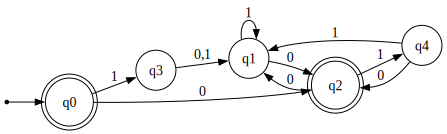

In [20]:
badr_dfa = DFA(
  states={'q0', 'q1', 'q2', 'q3', 'q4'},
  input_symbols={'0', '1'},
  transitions={
    'q0': {'0': 'q2', '1': 'q3'},
    'q1': {'0': 'q2', '1': 'q1'},
    'q2': {'0': 'q1', '1': 'q4'},
    'q3': {'0': 'q1', '1': 'q1'},
    'q4': {'0': 'q2', '1': 'q1'}
  },
  initial_state='q0',
  final_states={'q2', 'q0'},
)
badr_dfa

Just for the sake of completeness, below is the minified (in the standard way) automaton.

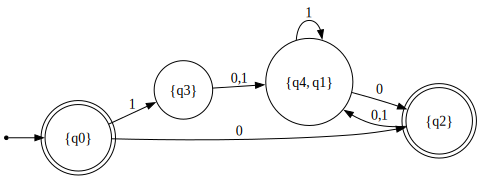

In [21]:
badr_dfa.minify(retain_names=True)

Finally, below is the hyper-minimized automaton obtained using respectively the Badr-Geffert-Shipman, Badr and Holzer-Maletti algorithms.

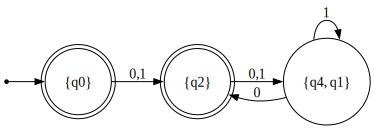

In [22]:
badr_geffert_shipman_hyper_minimize(badr_dfa)

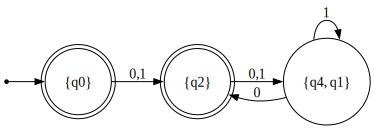

In [23]:
badr_hyper_minimize(badr_dfa)

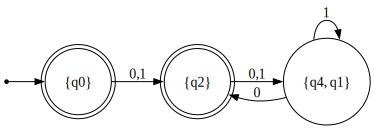

In [24]:
holzer_maletti_hyper_minimize(badr_dfa)

A little performance comparison is also provided.

In [25]:
print("Badr-Geffert-Shipman algorithm time:", timeit.timeit(lambda: badr_geffert_shipman_hyper_minimize(badr_dfa), number=10000))

Badr-Geffert-Shipman algorithm time: 1.6364722499856725


In [26]:
print("Badr algorithm time:", timeit.timeit(lambda: badr_hyper_minimize(badr_dfa), number=10000))

Badr algorithm time: 1.7055515840183944


In [27]:
print("Holzer-Maletti algorithm time:", timeit.timeit(lambda: holzer_maletti_hyper_minimize(badr_dfa), number=10000))

Holzer-Maletti algorithm time: 1.348100459028501


### Example 2

Here is another, more extended, example of DFA on which the hyper minimization will be performed from [An nlogn
algorithm for hyper-minimizing a (minimized) deterministic automaton](https://www.sciencedirect.com/science/article/pii/S030439751000321X) paper by Holzer and Maletti.

Note: the automaton is already minimized in the standard way.

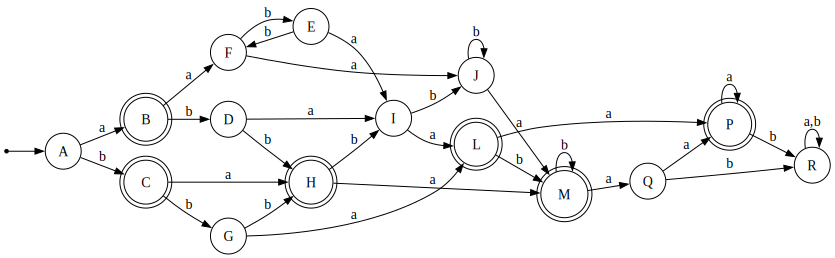

In [28]:
holzer_maletti_dfa = DFA(
  states={'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'P', 'Q', 'R'},
  input_symbols={'a', 'b'},
  initial_state='A',
  final_states={'B', 'C', 'H', 'M', 'L', 'P'},
  transitions={
    'A': {'a': 'B', 'b': 'C'},
    'B': {'a': 'F', 'b': 'D'},
    'C': {'a': 'H', 'b': 'G'},
    'D': {'a': 'I', 'b': 'H'},
    'E': {'a': 'I', 'b': 'F'},
    'F': {'a': 'J', 'b': 'E'},
    'G': {'a': 'L', 'b': 'H'},
    'H': {'a': 'M', 'b': 'I'},
    'I': {'a': 'L', 'b': 'J'},
    'J': {'a': 'M', 'b': 'J'},
    'L': {'a': 'P', 'b': 'M'},
    'M': {'a': 'Q', 'b': 'M'},
    'P': {'a': 'P', 'b': 'R'},
    'Q': {'a': 'P', 'b': 'R'},
    'R': {'a': 'R', 'b': 'R'}
  }
)
holzer_maletti_dfa

Now the hyper-minimization is performed using the defined algorithms.

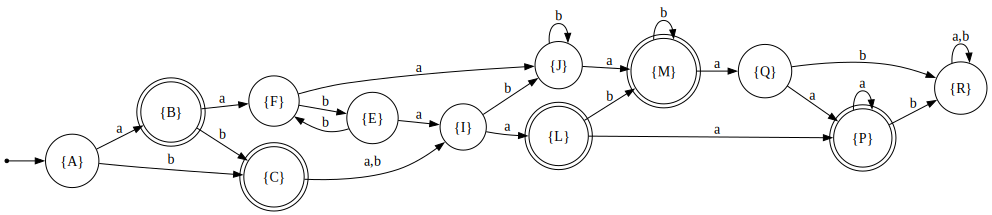

In [29]:
badr_geffert_shipman_hyper_minimize(holzer_maletti_dfa)

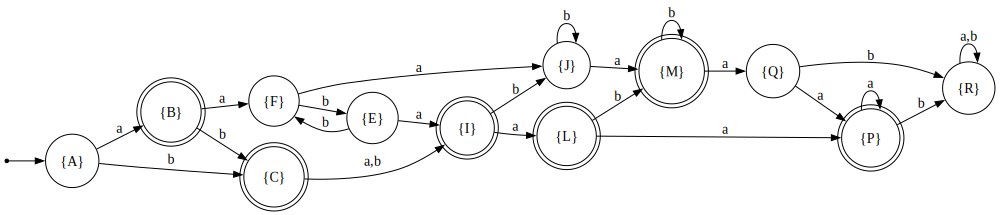

In [30]:
badr_hyper_minimize(holzer_maletti_dfa)

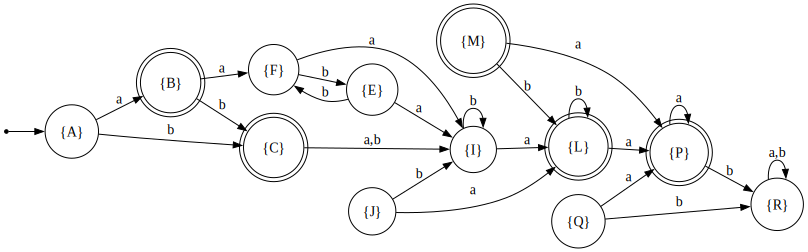

In [31]:
holzer_maletti_hyper_minimize(holzer_maletti_dfa)

Again, a preliminary performance comparison is provided.

In [32]:
print("Badr-Geffert-Shipman algorithm time:", timeit.timeit(lambda: badr_geffert_shipman_hyper_minimize(holzer_maletti_dfa), number=10000))

Badr-Geffert-Shipman algorithm time: 38.96716558403568


In [33]:
print("Badr algorithm time:", timeit.timeit(lambda: badr_hyper_minimize(holzer_maletti_dfa), number=10000))

Badr algorithm time: 9.454873583978042


In [34]:
print("Holzer-Maletti algorithm time:", timeit.timeit(lambda: holzer_maletti_hyper_minimize(holzer_maletti_dfa), number=10000))

Holzer-Maletti algorithm time: 5.37364233302651


### Proof of correctness

This section aims to demonstrate that each of the implemented algorithms generates a hyper-minimized automaton.

From the original paper: _an automaton $M$ is hyper-minimized if and only if, in $M$, $1$ there does not exist an unreachable state, $2$ there does not exist a pair of different but equivalent states, and $3$ there does not exist a pair of different but almost-equivalent states, such that at least one of them is a preamble state. (Two states are almost-equivalent if there exist at most finitely many input strings α such that, starting from these two states and reading α in parallel, we can reach a state pair with different acceptance values.) Note that the first two conditions alone characterize minimized automata._

Here is defined an algorithm which verifies if a given automaton is hyper-minimized:

In [35]:
def is_hyper_minimal(dfa: DFA):
  pass

### In-depth performance profiling

#### DFA generation

In [36]:
def generate_random_dfa(num_states, alphabet_size):
    """
    Generate a random Deterministic Finite Automaton (DFA).

    Parameters:
    - num_states (int): Number of states in the DFA.
    - alphabet_size (int): Size of the alphabet.

    Returns:
    - dict: DFA representation with the following keys:
        - 'states': List of states.
        - 'alphabet': List of alphabet symbols.
        - 'transitions': Dictionary representing transitions.
        - 'initial_state': Initial state.
        - 'final_states': List of final states.
    """
    dfa = IncrementalDFA()
    
    # states generation
    dfa.states = {'q' + str(i) for i in range(num_states)}
    
    # alphabet generation
    dfa.input_symbols = {'t' + str(i) for i in range(alphabet_size)}

    # transitions generation
    dfa.transitions = dict()
    for state in dfa.states:
        dfa.transitions[state] = dict()
        for symbol in dfa.input_symbols:
            dfa.transitions[state][symbol] = random.choice(list(dfa.states))

    # Randomly select initial and final states
    dfa.initial_state = random.choice(list(dfa.states))
    dfa.final_states = set(random.sample(list(dfa.states), random.randint(1, num_states)))

    return dfa.build()

A test suite generator function is defined below.

In [37]:
def generate_test_suite(groups = 10, tests_per_group = 100) -> list[list[DFA]]:
  """
  Generate a test suite for the hyper-minimization algorithms.

  Parameters:
  - groups (int): Number of groups of tests, automata in the i-th group contain 2^i states.
  - tests_per_group (int): Number of automata per group.

  Returns:
  - Test suite containing groups of test automata, each containing tests_per_group automata.
  """
  return [[generate_random_dfa(2 ** i, 2) for _ in range(tests_per_group)] for i in range(1, groups+1)]

A small function to run the test which prints the progress is defined below.

In [38]:
def run_tests(suite: list[list[DFA]], algorithm: callable) -> list[list[float]]:
  """
  Run a test suite of DFAs using a given algorithm.

  Parameters:
  - suite (list[list[DFA]]): Test suite of DFAs.
  - algorithm (function): Algorithm to be tested.

  Returns:
  - Matrix containing the execution times for each test case.
  """
  results = list[list[float]]()
  for i in range(len(suite)):
    results.append(list[float]())
    for j in range(len(suite[i])):
      print(f"Running test {i + 1}.{j + 1}.", end="\r")
      results[-1].append(timeit.timeit(lambda: algorithm(suite[i][j]), number=1))
    print("Test suite", i + 1, "completed.")
  return results

Generating and running the tests for the 3 algorithms.

In [39]:
test_suite = generate_test_suite(7, 1000)

In [40]:
badr_geffert_shipman_results = run_tests(test_suite, badr_geffert_shipman_hyper_minimize)

Test suite 1 completed.
Test suite 2 completed.
Test suite 3 completed.
Test suite 4 completed.
Test suite 5 completed.
Test suite 6 completed.
Test suite 7 completed.


In [41]:
badr_results = run_tests(test_suite, badr_hyper_minimize)

Test suite 1 completed.
Test suite 2 completed.
Test suite 3 completed.
Test suite 4 completed.
Test suite 5 completed.
Test suite 6 completed.
Test suite 7 completed.


In [42]:
holzer_maletti_results = run_tests(test_suite, holzer_maletti_hyper_minimize)

Test suite 1 completed.
Test suite 2 completed.
Test suite 3 completed.
Test suite 4 completed.
Test suite 5 completed.
Test suite 6 completed.
Test suite 7 completed.


In [43]:
badr_geffert_shipman_mean = [sum(badr_geffert_shipman_results[i]) / len(badr_geffert_shipman_results[i]) for i in range(len(badr_geffert_shipman_results))]
badr_mean = [sum(badr_results[i]) / len(badr_results[i]) for i in range(len(badr_results))]
holzer_maletti_mean = [sum(holzer_maletti_results[i]) / len(holzer_maletti_results[i]) for i in range(len(holzer_maletti_results))]

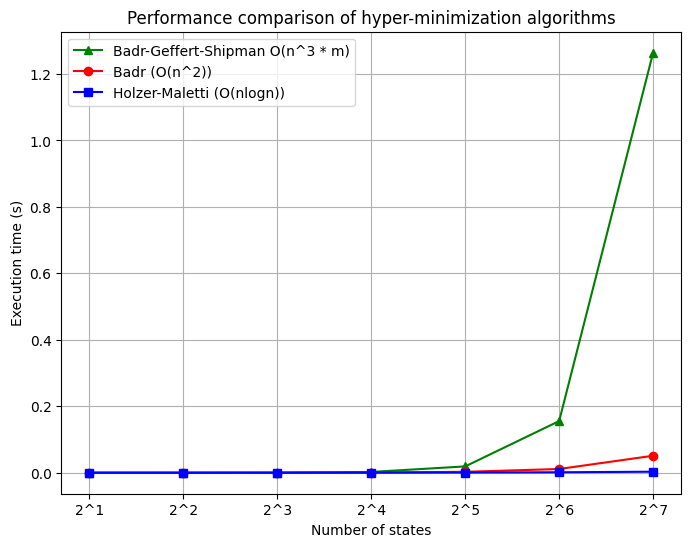

In [45]:
num_of_states = [f'2^{i}' for i in range(1, 8)]

plt.figure(figsize=(8, 6))
plt.plot(num_of_states, badr_geffert_shipman_mean, label='Badr-Geffert-Shipman O(n^3 * m)', color='green', marker='^')
plt.plot(num_of_states, badr_mean, label='Badr (O(n^2))', color='red', marker='o')
plt.plot(num_of_states, holzer_maletti_mean, label='Holzer-Maletti (O(nlogn))', color='blue', marker='s')

plt.title('Performance comparison of hyper-minimization algorithms')
plt.xlabel('Number of states')
plt.ylabel('Execution time (s)')

plt.legend()

plt.grid(True)
plt.show()


#### Performance comparison

A more in-depth analysis of the performance of the three algorithms is provided below using the `pyinstrument` library ang generating a `speedscope` profile that can be visualized [here](https://www.speedscope.app/).

In [49]:
%%pyinstrument

for i in range(1000):
  badr_geffert_shipman_hyper_minimize(holzer_maletti_dfa)

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:10:46  Samples:  9920
 /_//_/// /_\ / //_// / //_'/ //     Duration: 9.934     CPU time: 9.895
/   _/                      v4.6.2

Program: /Users/andrea/Desktop/uni/bachelor-thesis/code/py-playground/.venv/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/andrea/Library/Jupyter/runtime/kernel-v2-82001e0AXTLdxO9ca.json

9.933 <module>  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/2572538052.py:1
`- 9.919 badr_geffert_shipman_hyper_minimize  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1522450125.py:1
   |- 4.188 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1522450125.py
   |- 3.830 <genexpr>  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1522450125.py:38
   |  |- 3.044 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1522450125.py
   |  `- 0.786 IncrementalDFA.delta  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1062103209.py:28
   |- 0.695 DFA.minify  automata/fa/dfa.py:535
   |     [8 frames hidden]  automata
   |- 0.541 breadth_first_search  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/4119811839.py:1
   |  `- 0.322 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/4119811839.py
   |- 0.369 all  <built-in>
   `- 0.257 IncrementalDFA.build  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1062103209.py:34
      `- 0.253 DFA.__init__  automata/fa/dfa.py:105
            [4 frames hidden]  automata

In [48]:
%%pyinstrument

for i in range(1000):
  badr_hyper_minimize(holzer_maletti_dfa)

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:10:34  Samples:  3159
 /_//_/// /_\ / //_// / //_'/ //     Duration: 3.173     CPU time: 3.154
/   _/                      v4.6.2

Program: /Users/andrea/Desktop/uni/bachelor-thesis/code/py-playground/.venv/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/andrea/Library/Jupyter/runtime/kernel-v2-82001e0AXTLdxO9ca.json

3.172 <module>  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/97622153.py:1
`- 3.168 badr_hyper_minimize  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1741877194.py:1
   |- 1.607 f_equivalence_classes  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1180956331.py:1
   |  |- 1.027 right_finite_state  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/2306569026.py:1
   |  |  |- 0.676 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/2306569026.py
   |  |  |- 0.264 set.add  <built-in>
   |  |  `- 0.035 set.remove  <built-in>
   |  |- 0.421 xor_cross_product  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/3414771707.py:1
   |  |  |- 0.338 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/3414771707.py
   |  |  `- 0.080 set.add  <built-in>
   |  `- 0.117 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1180956331.py
   |- 0.669 DFA.minify  automata/fa/dfa.py:535
   |     [15 frames hidden]  automata
   |- 0.493 preamble_and_kernel  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/2039603915.py:1
   |  `- 0.473 breadth_first_search  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/4119811839.py:1
   |     |- 0.267 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/4119811839.py
   |     |- 0.066 IncrementalDFA.delta  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1062103209.py:28
   |     |- 0.063 list.pop  <built-in>
   |     |- 0.039 set.add  <built-in>
   |     `- 0.037 list.append  <built-in>
   |- 0.246 IncrementalDFA.build  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1062103209.py:34
   |  `- 0.241 DFA.__init__  automata/fa/dfa.py:105
   |        [10 frames hidden]  automata
   |- 0.094 f_merge_states  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/4138332111.py:1
   |  `- 0.062 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/4138332111.py
   `- 0.052 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1741877194.py

In [47]:
%%pyinstrument

for i in range(1000):
  holzer_maletti_hyper_minimize(holzer_maletti_dfa)

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:10:27  Samples:  1281
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.284     CPU time: 1.284
/   _/                      v4.6.2

Program: /Users/andrea/Desktop/uni/bachelor-thesis/code/py-playground/.venv/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/andrea/Library/Jupyter/runtime/kernel-v2-82001e0AXTLdxO9ca.json

1.284 <module>  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/439626311.py:1
`- 1.279 holzer_maletti_hyper_minimize  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/3141083044.py:1
   |- 0.660 DFA.minify  automata/fa/dfa.py:535
   |     [26 frames hidden]  automata, <built-in>, frozendict
   |- 0.243 almost_equivalent_states  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/224237870.py:1
   |  |- 0.101 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/224237870.py
   |  |- 0.090 merge  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/2308035245.py:1
   |  |  `- 0.087 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/2308035245.py
   |  `- 0.025 dict.values  <built-in>
   |- 0.226 IncrementalDFA.build  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1062103209.py:34
   |  `- 0.225 DFA.__init__  automata/fa/dfa.py:105
   |        [17 frames hidden]  automata, <built-in>, frozendict
   |- 0.101 compute_kernel  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/2819039847.py:1
   |  |- 0.074 tarjan  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1120094465.py:1
   |  |  `- 0.069 __tarjan  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1120094465.py:7
   |  |     |- 0.051 __tarjan  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1120094465.py:7
   |  |     |  `- 0.036 __tarjan  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1120094465.py:7
   |  |     |     `- 0.024 __tarjan  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1120094465.py:7
   |  |     |        `- 0.015 __tarjan  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1120094465.py:7
   |  |     `- 0.013 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/1120094465.py
   |  `- 0.024 __depth_first_search  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/2819039847.py:7
   `- 0.043 merge_states  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/828225908.py:1
      |- 0.022 merge  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/2308035245.py:1
      `- 0.013 [self]  ../../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_46104/828225908.py

In [40]:
with speedscope.track('badr_geffert_shipman.json'):
  badr_geffert_shipman_hyper_minimize(holzer_maletti_dfa)

In [41]:
with speedscope.track('badr.json'):
  badr_hyper_minimize(holzer_maletti_dfa)

In [42]:
with speedscope.track('holzer_maletti.json'):
  holzer_maletti_hyper_minimize(holzer_maletti_dfa)